(optional)

In [45]:
# from google.colab import drive
# import os
# drive.mount('/content/drive')

In [46]:
# os.chdir('...')

# **HW5: Brain signal classification**
In *HW 5*, you need to finish:

1.  Model Implementation Part: Implement LSTM and EEGNet models to predict the label of each samples.

2.  Model Competition Part: Implementing a model to reach better accuracy performance.

In [47]:
import numpy as np
import os
import math
import csv
import matplotlib.pyplot as plt
# Import the packages you need here
import tensorflow as tf
from tensorflow.keras import layers, models, constraints
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [48]:
data = np.load('data.npz')
label = np.load('label.npz')

In [49]:
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']

Y_train = label['Y_train']
Y_val = label['Y_val']

In [50]:
X_train.shape, X_val.shape, X_test.shape

((604, 22, 200), (152, 22, 200), (190, 22, 200))

In [51]:
def change_dim(X):
    temp = []
    for i in range(len(X)):
        temp.append(X[i].T.copy())
    return np.array(temp)

X_train_lstm = change_dim(X_train)
X_val_lstm = change_dim(X_val)
X_test_lstm = change_dim(X_test)

# (number of samples, time steps, number of features)
print(X_train_lstm.shape, X_val_lstm.shape, X_test_lstm.shape)

(604, 200, 22) (152, 200, 22) (190, 200, 22)


In [52]:
Y_train.shape, Y_val.shape

((604, 1), (152, 1))

In [53]:
Y_train = tf.keras.utils.to_categorical(Y_train, 6)
Y_val = tf.keras.utils.to_categorical(Y_val, 6)

print(Y_train.shape, Y_val.shape)

(604, 6) (152, 6)


## Model Implementation Part

### LSTM

In [54]:
# Build your model here:
lstm = models.Sequential()

lstm.add(layers.LSTM(units=64, input_shape=(200, 22), dropout=0.2))

lstm.add(layers.Dense(units=6, activation='softmax'))

lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                22272     
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
Total params: 22,662
Trainable params: 22,662
Non-trainable params: 0
_________________________________________________________________


In [55]:
lstm.compile(optimizer=Adam(),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

lstm_train_history = lstm.fit(X_train_lstm, Y_train,
                          validation_data=(X_val_lstm, Y_val),
                          batch_size=64,
                          epochs=200,
                          verbose=1)

Epoch 1/200
10/10 [==============================] - 2s 70ms/step - loss: 1.7797 - accuracy: 0.2682 - val_loss: 1.6346 - val_accuracy: 0.3092
Epoch 2/200
10/10 [==============================] - 0s 20ms/step - loss: 1.5885 - accuracy: 0.3791 - val_loss: 1.5015 - val_accuracy: 0.3882
Epoch 3/200
10/10 [==============================] - 0s 20ms/step - loss: 1.4626 - accuracy: 0.4205 - val_loss: 1.4285 - val_accuracy: 0.4276
Epoch 4/200
10/10 [==============================] - 0s 19ms/step - loss: 1.3778 - accuracy: 0.4934 - val_loss: 1.3781 - val_accuracy: 0.4671
Epoch 5/200
10/10 [==============================] - 0s 20ms/step - loss: 1.2796 - accuracy: 0.5281 - val_loss: 1.3320 - val_accuracy: 0.4671
Epoch 6/200
10/10 [==============================] - 0s 19ms/step - loss: 1.2067 - accuracy: 0.5811 - val_loss: 1.2955 - val_accuracy: 0.5000
Epoch 7/200
10/10 [==============================] - 0s 19ms/step - loss: 1.1316 - accuracy: 0.5877 - val_loss: 1.2649 - val_accuracy: 0.5066
Epoch 

Train loss: 0.006514330394566059
Train accuracy: 0.998344361782074
Validation loss: 0.19884523749351501
Validation accuracy: 0.9407894611358643


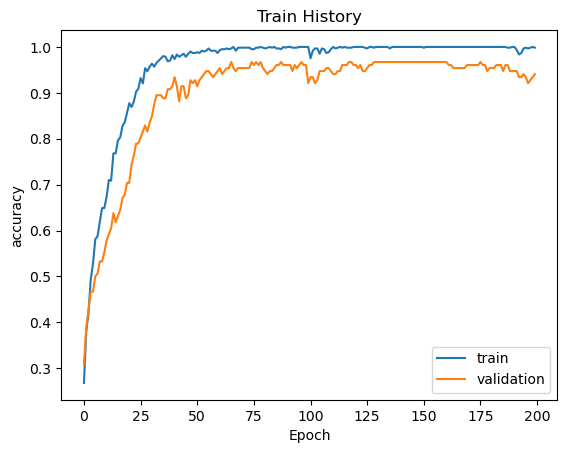

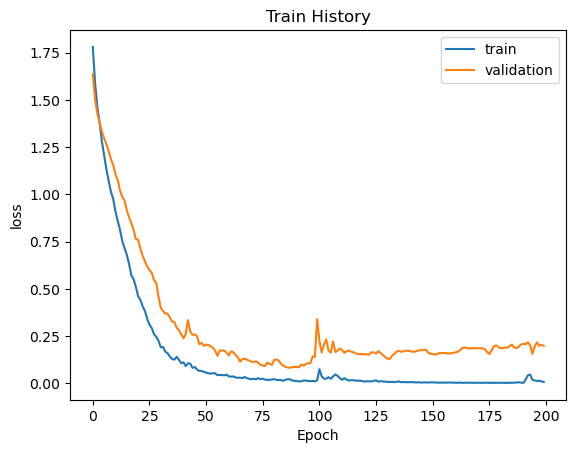

In [56]:
pred_train_lstm = lstm.evaluate(X_train_lstm, Y_train, verbose=0)
pred_val_lstm = lstm.evaluate(X_val_lstm, Y_val, verbose=0)

print("Train loss:", pred_train_lstm[0])
print("Train accuracy:", pred_train_lstm[1])
print("Validation loss:", pred_val_lstm[0])
print("Validation accuracy:", pred_val_lstm[1])

plt.plot(lstm_train_history.history['accuracy'])
plt.plot(lstm_train_history.history['val_accuracy'])
plt.title('Train History')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(lstm_train_history.history['loss'])
plt.plot(lstm_train_history.history['val_loss'])
plt.title('Train History')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [57]:
pred_test_lstm = lstm.predict(X_test_lstm)
pred_test_lstm = np.argmax(pred_test_lstm, axis = 1)
pred_test_lstm = pred_test_lstm.reshape((-1, 1))

6/6 [==============================] - 0s 6ms/step


In [58]:
output = pred_test_lstm
assert(output.shape == (190, 1))
np.savetxt('lstm_output.csv', output, delimiter=",")

### EEGNet

In [59]:
X_train_eegnet = X_train.reshape(X_train.shape+(1, ))
X_val_eegnet = X_val.reshape(X_val.shape+(1, ))
X_test_eegnet = X_test.reshape(X_test.shape+(1, ))

# (number of samples, number of features(channel size), time steps)
print(X_train_eegnet.shape, X_val_eegnet.shape, X_test_eegnet.shape)

(604, 22, 200, 1) (152, 22, 200, 1) (190, 22, 200, 1)


In [60]:
F1 = 16
F2 = 32
C = 22
D = 2
T = 200
p = 0.5

# Build your model here:
eegnet = models.Sequential([
    # block1
    layers.Conv2D(filters=F1, kernel_size=(1, 64), padding='same', input_shape=(C, T, 1), use_bias=False),
    layers.BatchNormalization(),
    layers.DepthwiseConv2D(kernel_size=(C, 1), padding='valid', depth_multiplier=D, depthwise_constraint=constraints.max_norm(1.), use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('elu'),
    layers.AveragePooling2D(pool_size=(1, 4)),
    layers.Dropout(p),
    # # block2
    layers.SeparableConv2D(filters=F2, kernel_size=(1, 16), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('elu'),
    layers.AveragePooling2D(pool_size=(1, 8)),
    layers.Dropout(p),
    layers.Flatten(),
    layers.Dense(units=6, kernel_constraint=constraints.max_norm(0.25)),
    layers.Activation('softmax')
])

eegnet.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 22, 200, 16)       1024      
                                                                 
 batch_normalization_6 (Batc  (None, 22, 200, 16)      64        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_2 (Depthwi  (None, 1, 200, 32)       704       
 seConv2D)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 1, 200, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 1, 200, 32)        0         
                                                      

In [61]:
eegnet.compile(optimizer=Adam(),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

eegnet_train_history = eegnet.fit(X_train_eegnet, Y_train,
                          validation_data=(X_val_eegnet, Y_val),
                          batch_size=64,
                          epochs=200,
                          verbose=1)

Epoch 1/200
10/10 [==============================] - 1s 47ms/step - loss: 1.7309 - accuracy: 0.3179 - val_loss: 1.7158 - val_accuracy: 0.5658
Epoch 2/200
10/10 [==============================] - 0s 28ms/step - loss: 1.4852 - accuracy: 0.6374 - val_loss: 1.6386 - val_accuracy: 0.7500
Epoch 3/200
10/10 [==============================] - 0s 28ms/step - loss: 1.2874 - accuracy: 0.7235 - val_loss: 1.5685 - val_accuracy: 0.7303
Epoch 4/200
10/10 [==============================] - 0s 28ms/step - loss: 1.1098 - accuracy: 0.7798 - val_loss: 1.5080 - val_accuracy: 0.7763
Epoch 5/200
10/10 [==============================] - 0s 28ms/step - loss: 0.9477 - accuracy: 0.8460 - val_loss: 1.4257 - val_accuracy: 0.8618
Epoch 6/200
10/10 [==============================] - 0s 28ms/step - loss: 0.8589 - accuracy: 0.8510 - val_loss: 1.3522 - val_accuracy: 0.8816
Epoch 7/200
10/10 [==============================] - 0s 28ms/step - loss: 0.7686 - accuracy: 0.8758 - val_loss: 1.2941 - val_accuracy: 0.9211
Epoch 

Train loss: 0.0412924699485302
Train accuracy: 1.0
Validation loss: 0.06216954067349434
Validation accuracy: 0.9934210777282715


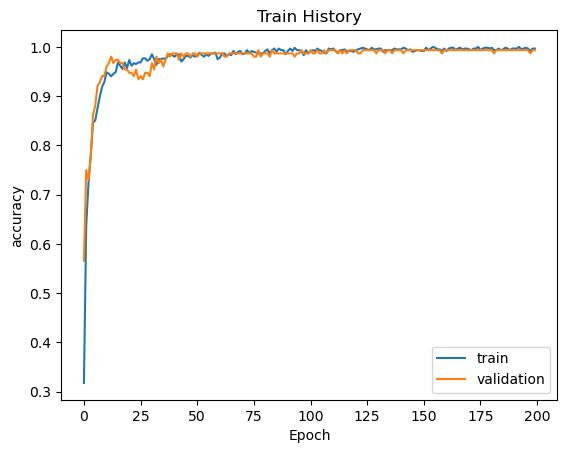

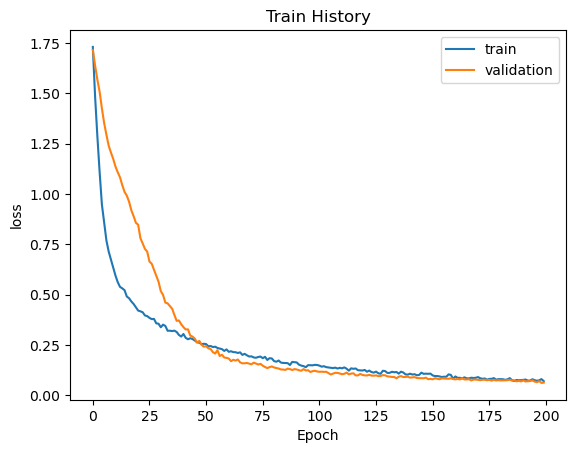

In [62]:
pred_train_eegnet = eegnet.evaluate(X_train_eegnet, Y_train, verbose=0)
pred_val_eegnet = eegnet.evaluate(X_val_eegnet, Y_val, verbose=0)

print("Train loss:", pred_train_eegnet[0])
print("Train accuracy:", pred_train_eegnet[1])
print("Validation loss:", pred_val_eegnet[0])
print("Validation accuracy:", pred_val_eegnet[1])

plt.plot(eegnet_train_history.history['accuracy'])
plt.plot(eegnet_train_history.history['val_accuracy'])
plt.title('Train History')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(eegnet_train_history.history['loss'])
plt.plot(eegnet_train_history.history['val_loss'])
plt.title('Train History')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [63]:
pred_test_eegnet = eegnet.predict(X_test_eegnet)
pred_test_eegnet = np.argmax(pred_test_eegnet, axis = 1)
pred_test_eegnet = pred_test_eegnet.reshape((-1, 1))

6/6 [==============================] - 0s 3ms/step


In [64]:
output = pred_test_eegnet
assert(output.shape == (190, 1))
np.savetxt('eegnet_output.csv', output, delimiter=",")

## Model Competition Part

In [65]:
# Build your model here:


In [66]:
output = pred_test_eegnet
assert(output.shape == (190, 1))
np.savetxt('competition_output.csv', output, delimiter=",")